In [49]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder


In [50]:
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    warnings.filterwarnings("ignore", category=DeprecationWarning)

We are taking a ravdess emotion dataset

In [51]:
Ravd = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

In [52]:
dirl = os.listdir(Ravd)
dirl.sort()
emotion = []
gender = []
path = []
for i in dirl:
    fname = os.listdir(Ravd + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(Ravd + i + '/' + f)


In [53]:
RAVD_df = pd.DataFrame(emotion)
RAVD_df = RAVD_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAVD_df = pd.concat([pd.DataFrame(gender),RAVD_df],axis=1)
RAVD_df.columns = ['gender','emotion']
RAVD_df['labels'] =RAVD_df.gender + '_' + RAVD_df.emotion
RAVD_df['source'] = 'RAVDESS'  
RAVD_df = pd.concat([RAVD_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAVD_df = RAVD_df.drop(['gender', 'emotion'], axis=1)
RAVD_df.labels.value_counts()

male_neutral       144
female_neutral     144
male_sad            96
male_fear           96
male_happy          96
male_disgust        96
male_angry          96
male_surprise       96
female_surprise     96
female_disgust      96
female_fear         96
female_sad          96
female_happy        96
female_angry        96
Name: labels, dtype: int64

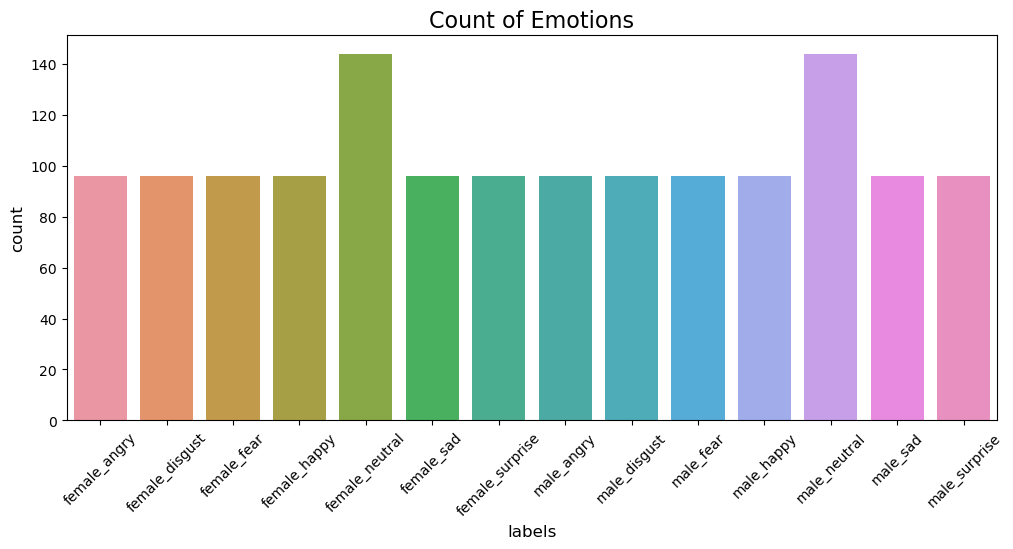

In [54]:
plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
RAVD_df['labels'] = RAVD_df['labels'].astype('category')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.countplot(x='labels', data=RAVD_df)
plt.show()

Female-sad emotion

In [55]:
fRA01= Ravd + '/Actor_06/03-01-04-01-02-02-06.wav'
data, sr = librosa.load(fRA01)
ipd.Audio(data, rate=sr)

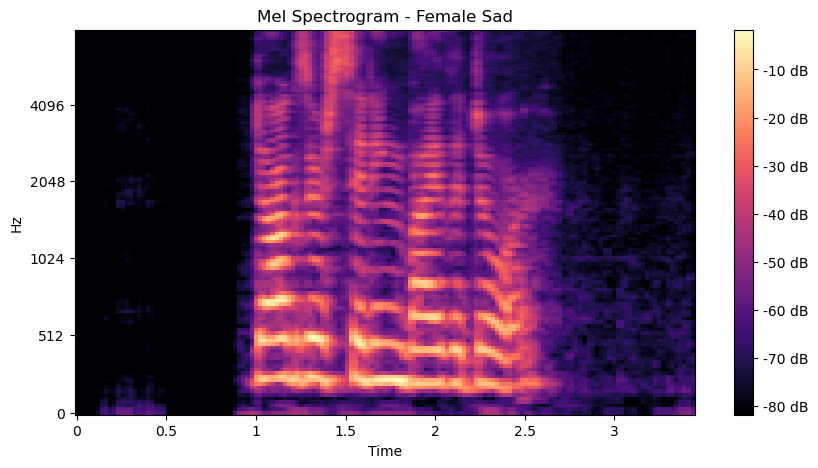

In [56]:
plt.figure(figsize=(10,5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram,y_axis='mel',fmax=8000,x_axis='time');
plt.title('Mel Spectrogram - Female Sad')
plt.colorbar(format='%+2.0f dB');

Female-happy emotion

In [57]:
fRA02= Ravd + '/Actor_06/03-01-03-02-02-01-06.wav'
data, sr = librosa.load(fRA02)
ipd.Audio(data, rate=sr)

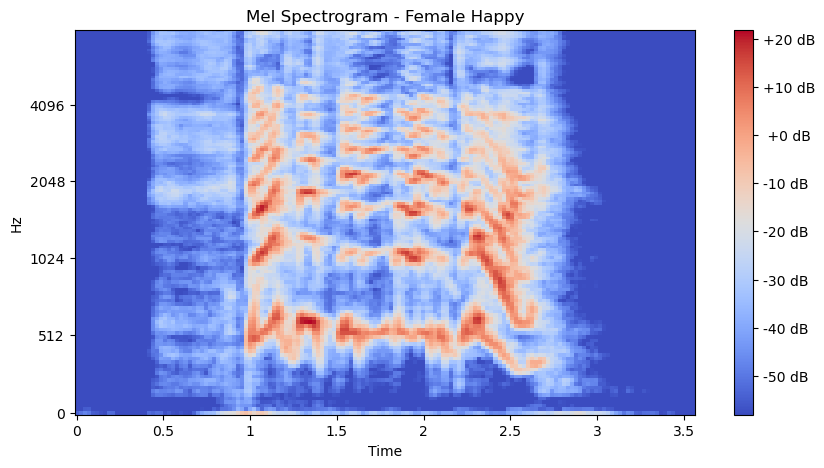

In [58]:
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram,y_axis='mel',fmax=8000,x_axis='time');
plt.title('Mel Spectrogram - Female Happy')
plt.colorbar(format='%+3.0f dB');

Male-sad

In [59]:
fRA11= Ravd + '/Actor_05/03-01-04-01-02-02-05.wav'
data, sr = librosa.load(fRA11)
ipd.Audio(data, rate=sr)

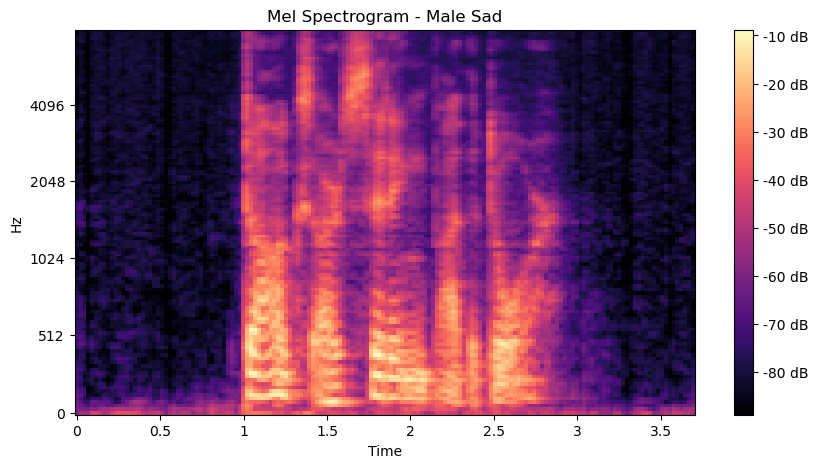

In [60]:
plt.figure(figsize=(10,5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram,y_axis='mel',fmax=8000,x_axis='time');
plt.title('Mel Spectrogram - Male Sad')
plt.colorbar(format='%+2.0f dB');

Male-Happy emotion

In [61]:
fRA12= Ravd + '/Actor_05/03-01-03-01-02-02-05.wav'
data, sr = librosa.load(fRA12)
ipd.Audio(data, rate=sr)

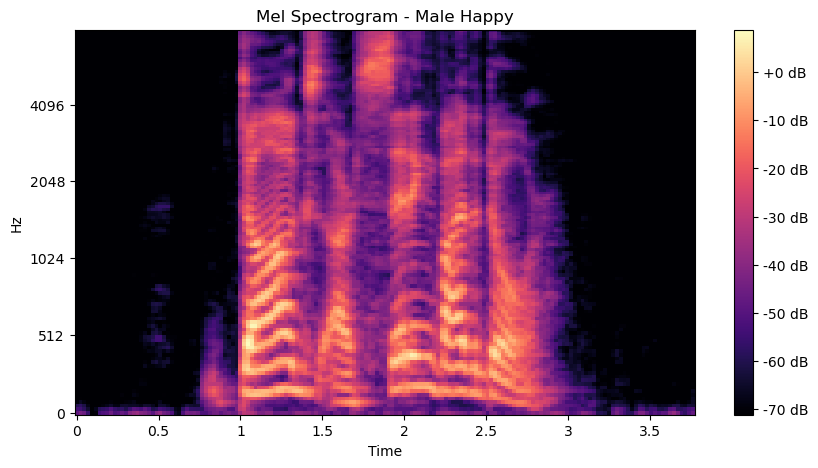

In [62]:
plt.figure(figsize=(10,5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram,y_axis='mel',fmax=8000,x_axis='time');
plt.title('Mel Spectrogram - Male Happy')
plt.colorbar(format='%+2.0f dB');

# DATA AUGMENTATION

In [63]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

In [64]:
path = np.array(RAVD_df['path'])[472]
data, sample_rate = librosa.load(path)

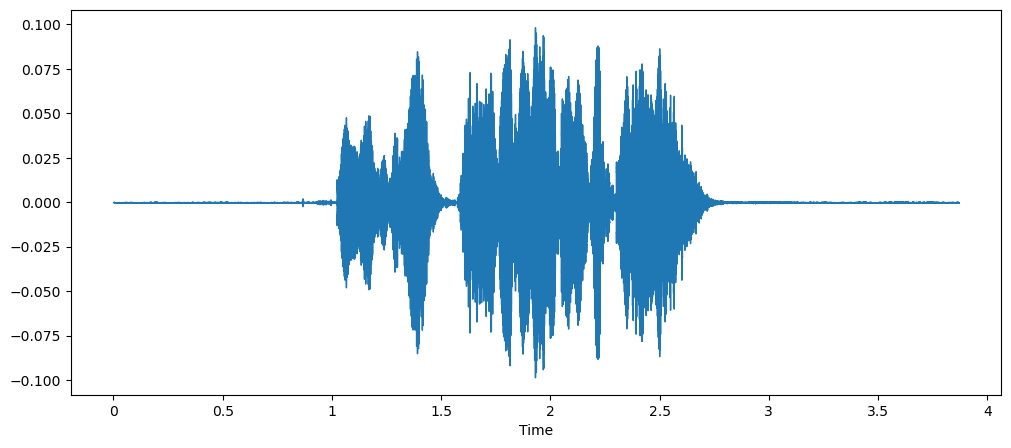

In [65]:
# NORMAL AUDIO
import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

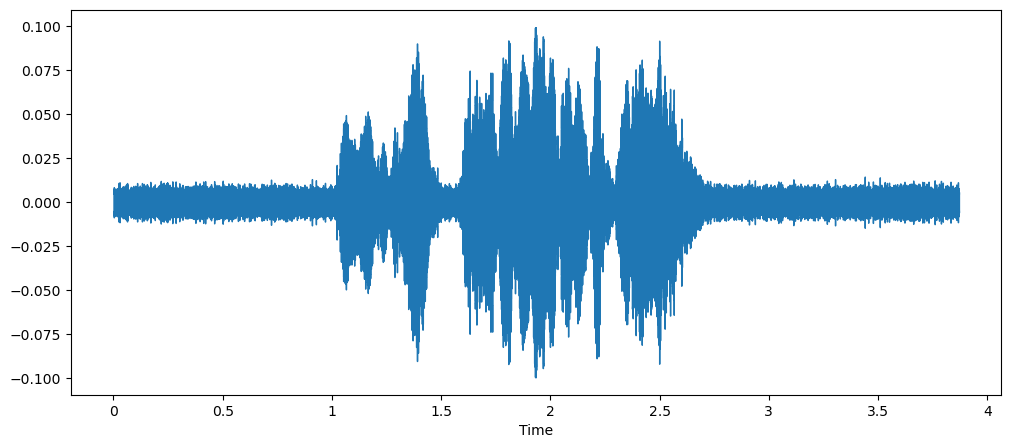

In [66]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

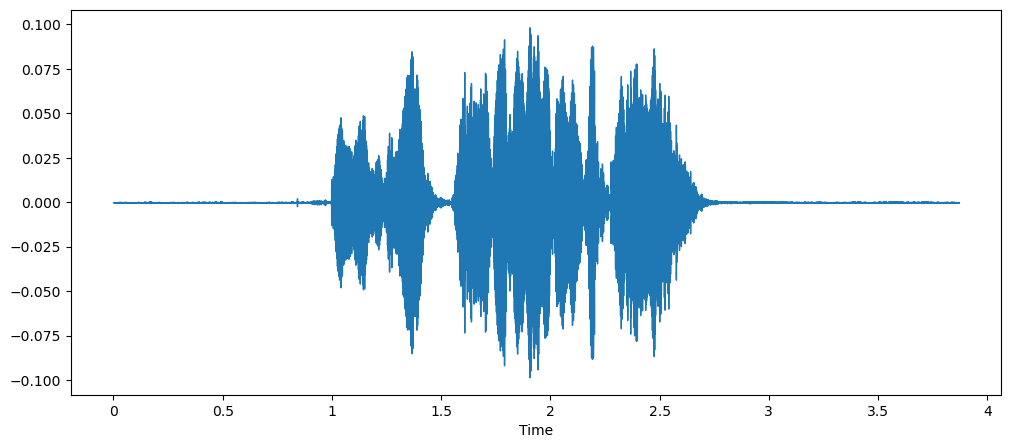

In [67]:
#SHIFT
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

After listening to all audio we determine to use noise, shift 

# FEATURE EXTRACTION

In [68]:
def feat_ext(data):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return mfcc

def get_feat(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # normal data
    res1 = feat_ext(data)
    result = np.array(res1)
    #data with noise
    noise_data = noise(data)
    res2 = feat_ext(noise_data)
    result = np.vstack((result, res2))
    return result


In [69]:
RAVD_df.head()

,labels,source,path
0,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...
1,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...
2,male_sad,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...
3,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...
4,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...


In [70]:
x,y = [], []
for path, emotion in zip(RAVD_df['path'], RAVD_df['labels']):
    feature = get_feat(path)
    for ele in feature:
        x.append(ele)
        y.append(emotion)

In [71]:
Emotions = pd.DataFrame(x)
Emotions['labels'] = y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-625.931702,93.350380,-0.155195,17.286949,10.036393,1.489274,-2.192932,-9.047087,-11.909074,-7.097077,...,-3.256781,1.268612,-5.854220,0.135247,1.014626,-8.251888,-3.210727,-1.189508,-1.944406,male_neutral
1,-419.709659,32.612213,13.425162,9.252411,4.982463,2.074565,-2.474183,-7.050887,-7.731093,-5.315812,...,0.240241,-0.572240,-1.626386,-0.786971,-0.928113,-4.458528,-3.580210,0.041871,-3.564372,male_neutral
2,-634.663269,72.324059,-2.998577,20.209738,10.674218,-1.151012,-2.813592,-7.923955,-16.231960,-2.627547,...,-4.167823,0.719303,-4.954943,-0.688256,0.114428,-6.475232,-1.695713,-2.899728,0.377744,male_neutral
3,-401.829305,22.742219,9.004475,8.835870,5.120418,0.241744,-1.808026,-5.732244,-7.690900,-4.548309,...,-2.494105,-2.077295,-1.942758,-1.230462,-0.653389,-2.675282,-2.035757,-0.532334,-2.597691,male_neutral
4,-545.842957,75.552429,-7.326171,15.582721,5.483204,-5.394440,-12.862757,-10.571244,-22.535200,-6.545372,...,-10.323301,0.508137,-7.265550,-7.588874,1.807155,-13.500458,-5.044713,-1.064428,-3.950340,male_sad


In [72]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-625.931702,93.350380,-0.155195,17.286949,10.036393,1.489274,-2.192932,-9.047087,-11.909074,-7.097077,...,-3.256781,1.268612,-5.854220,0.135247,1.014626,-8.251888,-3.210727,-1.189508,-1.944406,male_neutral
1,-419.709659,32.612213,13.425162,9.252411,4.982463,2.074565,-2.474183,-7.050887,-7.731093,-5.315812,...,0.240241,-0.572240,-1.626386,-0.786971,-0.928113,-4.458528,-3.580210,0.041871,-3.564372,male_neutral
2,-634.663269,72.324059,-2.998577,20.209738,10.674218,-1.151012,-2.813592,-7.923955,-16.231960,-2.627547,...,-4.167823,0.719303,-4.954943,-0.688256,0.114428,-6.475232,-1.695713,-2.899728,0.377744,male_neutral
3,-401.829305,22.742219,9.004475,8.835870,5.120418,0.241744,-1.808026,-5.732244,-7.690900,-4.548309,...,-2.494105,-2.077295,-1.942758,-1.230462,-0.653389,-2.675282,-2.035757,-0.532334,-2.597691,male_neutral
4,-545.842957,75.552429,-7.326171,15.582721,5.483204,-5.394440,-12.862757,-10.571244,-22.535200,-6.545372,...,-10.323301,0.508137,-7.265550,-7.588874,1.807155,-13.500458,-5.044713,-1.064428,-3.950340,male_sad


# DATA PREPROCESSING

In [73]:
x = Emotions.iloc[: ,:-1].values
y= Emotions['labels'].values

In [74]:
# As this is a multiclass classification problem onehotencoding our Y
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()
# Train and Test Split 
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2160, 20), (2160, 14), (720, 20), (720, 14))

In [75]:
# Reshape for LSTM 
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [76]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2160, 20), (2160, 14), (720, 20), (720, 14))

In [77]:
model=Sequential()
model.add(LSTM(512,return_sequences=True,input_shape=(40,1)))
model.add(LSTM(512,activation = 'relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(LSTM(256,activation = 'relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(LSTM(128,activation = 'relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(16))
model.add(LSTM(64,activation = 'relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(14))
model.add(Activation('softmax'))
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])

In [78]:
X_train_padded = np.pad(X_train, ((0,0), (20,0), (0,0)), mode='constant')

# Pad the test data
X_test_padded = np.pad(X_test, ((0,0), (20,0), (0,0)), mode='constant')

# Now, the input data has the expected shape of (None, 40, 1)
# We can train the model on the padded input data

model.fit(X_train_padded, y_train, epochs=100, validation_data=(X_test_padded, y_test), batch_size=65, verbose=1)

Epoch 1/100
34/34 [==============================] - 53s 1s/step - loss: 0.0657 - accuracy: 0.1310 - val_loss: 0.0643 - val_accuracy: 0.1583
Epoch 2/100
34/34 [==============================] - 42s 1s/step - loss: 0.0636 - accuracy: 0.1921 - val_loss: 0.0635 - val_accuracy: 0.1819
Epoch 3/100
34/34 [==============================] - 42s 1s/step - loss: 0.0628 - accuracy: 0.2065 - val_loss: 0.0628 - val_accuracy: 0.2181
Epoch 4/100
34/34 [==============================] - 42s 1s/step - loss: 0.0619 - accuracy: 0.2199 - val_loss: 0.0631 - val_accuracy: 0.1819
Epoch 5/100
34/34 [==============================] - 42s 1s/step - loss: 0.0621 - accuracy: 0.2194 - val_loss: 0.0618 - val_accuracy: 0.2097
Epoch 6/100
34/34 [==============================] - 41s 1s/step - loss: 0.0616 - accuracy: 0.2343 - val_loss: 0.0613 - val_accuracy: 0.2319
Epoch 7/100
34/34 [==============================] - 41s 1s/step - loss: 0.0610 - accuracy: 0.2444 - val_loss: 0.0616 - val_accuracy: 0.2278
Epoch 8/100
3

# UTILIZING MODELS

**Decision Tree**

In [79]:
from sklearn.tree import DecisionTreeClassifier
clf1 = DecisionTreeClassifier()
clf1 = clf1.fit(x_train,y_train)
y_pred = clf1.predict(x_test)

In [80]:
print("Training set score: {:.3f}".format(clf1.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf1.score(x_test, y_test)))

Training set score: 1.000
Test set score: 0.410


After Using the decision tree model in our dataset then the model goes in overfitting he gave accuracy around 0.385

**KNN**

In [81]:
from sklearn.neighbors import KNeighborsClassifier
clf2=KNeighborsClassifier(n_neighbors=4)
clf2.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=4)

In [82]:
y_pred=clf2.predict(x_test)

In [83]:
print("Training set score: {:.3f}".format(clf2.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf2.score(x_test, y_test)))

Training set score: 0.533
Test set score: 0.324


Using KNN in our dataset the overall training is quite good but not for deployment and test accuracy has 0.336

**MLP CLASSIFIER**

In [84]:
from sklearn.neural_network import MLPClassifier
clf3=MLPClassifier(alpha=0.01, batch_size=270, epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive', max_iter=400)
clf3.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=270, hidden_layer_sizes=(400,),
              learning_rate='adaptive', max_iter=400)

In [85]:
print("Training set score: {:.3f}".format(clf3.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf3.score(x_test, y_test)))

Training set score: 0.922
Test set score: 0.590


Using MLP Classifier he gave good accuracy in training dataset butit is not good for our test set, So we did not use it for deployment

# GRU

In [86]:
model03 = Sequential()
model03.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model03.add(Dropout(0.3))
model03.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model03.add(Dropout(0.3))
model03.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model03.add(Dropout(0.3))
model03.add(GRU(units=50, activation='tanh'))
model03.add(Dropout(0.3))
model03.add(Dense(units=14))
model03.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False), loss='mean_squared_error', metrics=['accuracy'])


In [87]:
model03.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 20, 50)            7950      
                                                                 
 dropout_15 (Dropout)        (None, 20, 50)            0         
                                                                 
 gru_5 (GRU)                 (None, 20, 50)            15300     
                                                                 
 dropout_16 (Dropout)        (None, 20, 50)            0         
                                                                 
 gru_6 (GRU)                 (None, 20, 50)            15300     
                                                                 
 dropout_17 (Dropout)        (None, 20, 50)            0         
                                                                 
 gru_7 (GRU)                 (None, 50)               

In [88]:
model03.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=200)

Epoch 1/100
11/11 [==============================] - 11s 284ms/step - loss: 0.1005 - accuracy: 0.0764 - val_loss: 0.0721 - val_accuracy: 0.0722
Epoch 2/100
11/11 [==============================] - 1s 118ms/step - loss: 0.0817 - accuracy: 0.0778 - val_loss: 0.0694 - val_accuracy: 0.0514
Epoch 3/100
11/11 [==============================] - 1s 116ms/step - loss: 0.0751 - accuracy: 0.0708 - val_loss: 0.0675 - val_accuracy: 0.0792
Epoch 4/100
11/11 [==============================] - 1s 117ms/step - loss: 0.0725 - accuracy: 0.0745 - val_loss: 0.0664 - val_accuracy: 0.1083
Epoch 5/100
11/11 [==============================] - 1s 115ms/step - loss: 0.0712 - accuracy: 0.0949 - val_loss: 0.0661 - val_accuracy: 0.1194
Epoch 6/100
11/11 [==============================] - 1s 114ms/step - loss: 0.0705 - accuracy: 0.0926 - val_loss: 0.0658 - val_accuracy: 0.1597
Epoch 7/100
11/11 [==============================] - 1s 115ms/step - loss: 0.0702 - accuracy: 0.1009 - val_loss: 0.0657 - val_accuracy: 0.183

In [89]:
print("Accuracy of our model on test data : " , model03.evaluate(X_test,y_test)[1]*100 , "%")

23/23 [==============================] - 0s 12ms/step - loss: 0.0642 - accuracy: 0.2000
Accuracy of our model on test data :  20.000000298023224 %


GRU(Gated Recurrent Unit) is important when we use speech dataset but in this model, we don't have good accuracy in training set as well as testing so we do not take for further deployment.

# LSTM

In [90]:
model13=Sequential()
model13.add(LSTM(70,return_sequences=True,input_shape=(20,1)))
model13.add(LSTM(50,return_sequences=True))
model13.add(LSTM(60))
model13.add(Dense(14))
model13.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])

In [91]:
model13.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 20, 70)            20160     
                                                                 
 lstm_18 (LSTM)              (None, 20, 50)            24200     
                                                                 
 lstm_19 (LSTM)              (None, 60)                26640     
                                                                 
 dense_15 (Dense)            (None, 14)                854       
                                                                 
Total params: 71,854
Trainable params: 71,854
Non-trainable params: 0
_________________________________________________________________


In [92]:
 model13.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=65,verbose=1)

Epoch 1/100
34/34 [==============================] - 9s 89ms/step - loss: 0.0652 - accuracy: 0.1773 - val_loss: 0.0626 - val_accuracy: 0.2444
Epoch 2/100
34/34 [==============================] - 2s 49ms/step - loss: 0.0616 - accuracy: 0.2523 - val_loss: 0.0616 - val_accuracy: 0.2472
Epoch 3/100
34/34 [==============================] - 2s 48ms/step - loss: 0.0612 - accuracy: 0.2611 - val_loss: 0.0608 - val_accuracy: 0.2750
Epoch 4/100
34/34 [==============================] - 2s 48ms/step - loss: 0.0603 - accuracy: 0.2889 - val_loss: 0.0599 - val_accuracy: 0.2792
Epoch 5/100
34/34 [==============================] - 2s 47ms/step - loss: 0.0598 - accuracy: 0.2866 - val_loss: 0.0598 - val_accuracy: 0.2931
Epoch 6/100
34/34 [==============================] - 2s 48ms/step - loss: 0.0593 - accuracy: 0.2880 - val_loss: 0.0589 - val_accuracy: 0.2986
Epoch 7/100
34/34 [==============================] - 2s 48ms/step - loss: 0.0584 - accuracy: 0.3139 - val_loss: 0.0588 - val_accuracy: 0.3056
Epoch 

In [93]:
print("Accuracy of our model on test data : " , model13.evaluate(X_test,y_test)[1]*100 , "%")

23/23 [==============================] - 0s 11ms/step - loss: 0.0462 - accuracy: 0.5833
Accuracy of our model on test data :  58.33333134651184 %


So, After all, the model ran we use LSTM is important when using sequence data like speech, So using this it ran good on train set but in the test is not so good i.e. 55.28 percentage.

# CNN

In [94]:
#CNN
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((2160, 20, 1), (2160, 14), (720, 20, 1), (720, 14))

In [95]:
#CNN
import tensorflow as tf 
model = Sequential()
model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(LSTM(256, return_sequences=True))

model.add(LSTM(128))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(14, activation='softmax'))

optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 20, 2048)          12288     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 10, 2048)         0         
 1D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 10, 2048)         8192      
 hNormalization)                                                 
                                                                 
 conv1d_4 (Conv1D)           (None, 10, 1024)          10486784  
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 5, 1024)          0         
 1D)                                                             
                                                      

In [96]:
#CNN
history = model.fit(x_traincnn, y_train, batch_size=64, epochs=150, validation_data=(x_testcnn, y_test))

Epoch 1/150
34/34 [==============================] - 112s 3s/step - loss: 2.6104 - accuracy: 0.1093 - val_loss: 2.6336 - val_accuracy: 0.0972
Epoch 2/150
34/34 [==============================] - 104s 3s/step - loss: 2.5506 - accuracy: 0.1519 - val_loss: 2.6293 - val_accuracy: 0.0958
Epoch 3/150
34/34 [==============================] - 102s 3s/step - loss: 2.4874 - accuracy: 0.1782 - val_loss: 2.6246 - val_accuracy: 0.0944
Epoch 4/150
34/34 [==============================] - 103s 3s/step - loss: 2.4378 - accuracy: 0.1912 - val_loss: 2.6134 - val_accuracy: 0.0944
Epoch 5/150
34/34 [==============================] - 103s 3s/step - loss: 2.3530 - accuracy: 0.2148 - val_loss: 2.6351 - val_accuracy: 0.0944
Epoch 6/150
34/34 [==============================] - 104s 3s/step - loss: 2.3052 - accuracy: 0.2074 - val_loss: 2.5850 - val_accuracy: 0.1528
Epoch 7/150
34/34 [==============================] - 103s 3s/step - loss: 2.2603 - accuracy: 0.2185 - val_loss: 2.6050 - val_accuracy: 0.1514
Epoch 

In [97]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

23/23 [==============================] - 2s 92ms/step - loss: 1.7151 - accuracy: 0.7556
Accuracy of our model on test data :  75.55555701255798 %


So Using all models we use last but not least CNN after using the CNN model we got good accuracy in the train as well as test if you saw the test accuracy above cell is quite good so we use further deployment

# Loss Accuracy Plot Using CNN

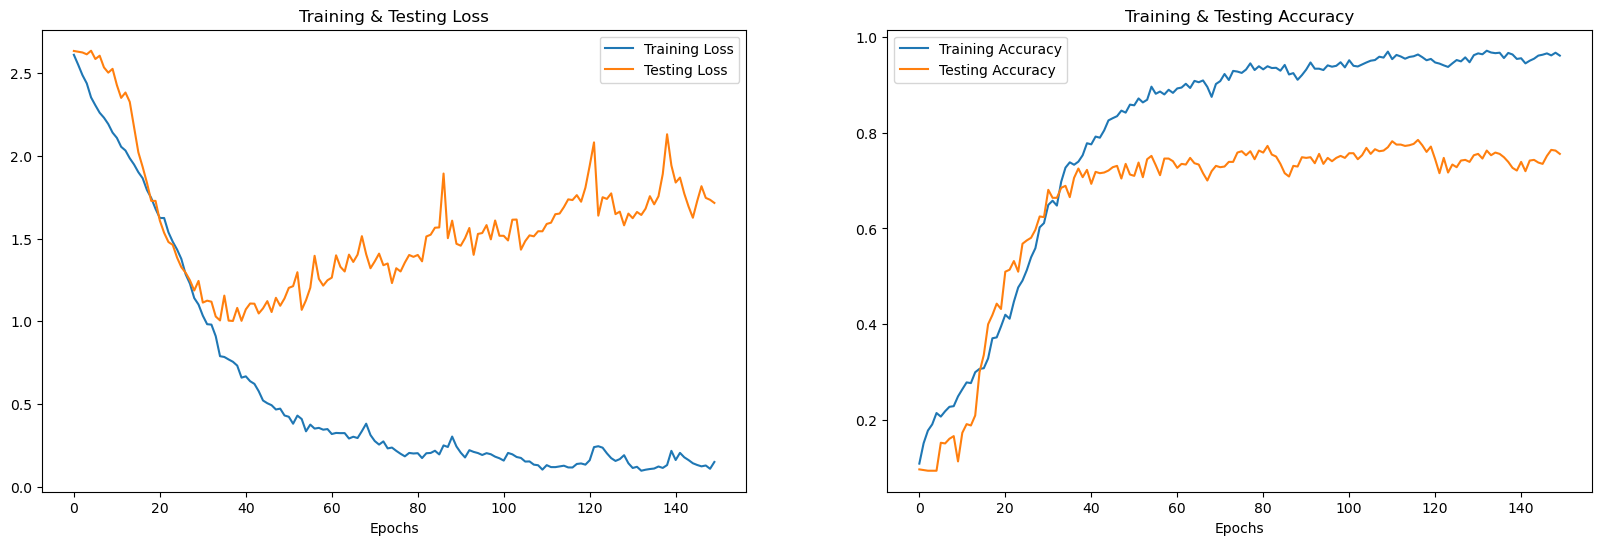

In [98]:
#CNN
epochs = [i for i in range(150)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [99]:
#CNN
pred_test = model.predict(x_testcnn)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

23/23 [==============================] - 3s 75ms/step


,Predicted Labels,Actual Labels
0,male_neutral,male_happy
1,male_happy,male_happy
2,female_angry,female_angry
3,female_sad,female_neutral
4,female_disgust,female_disgust
5,male_neutral,male_neutral
6,female_fear,female_happy
7,female_sad,female_sad
8,female_sad,female_sad
9,female_sad,female_sad


# Confusion Matrix Using CNN

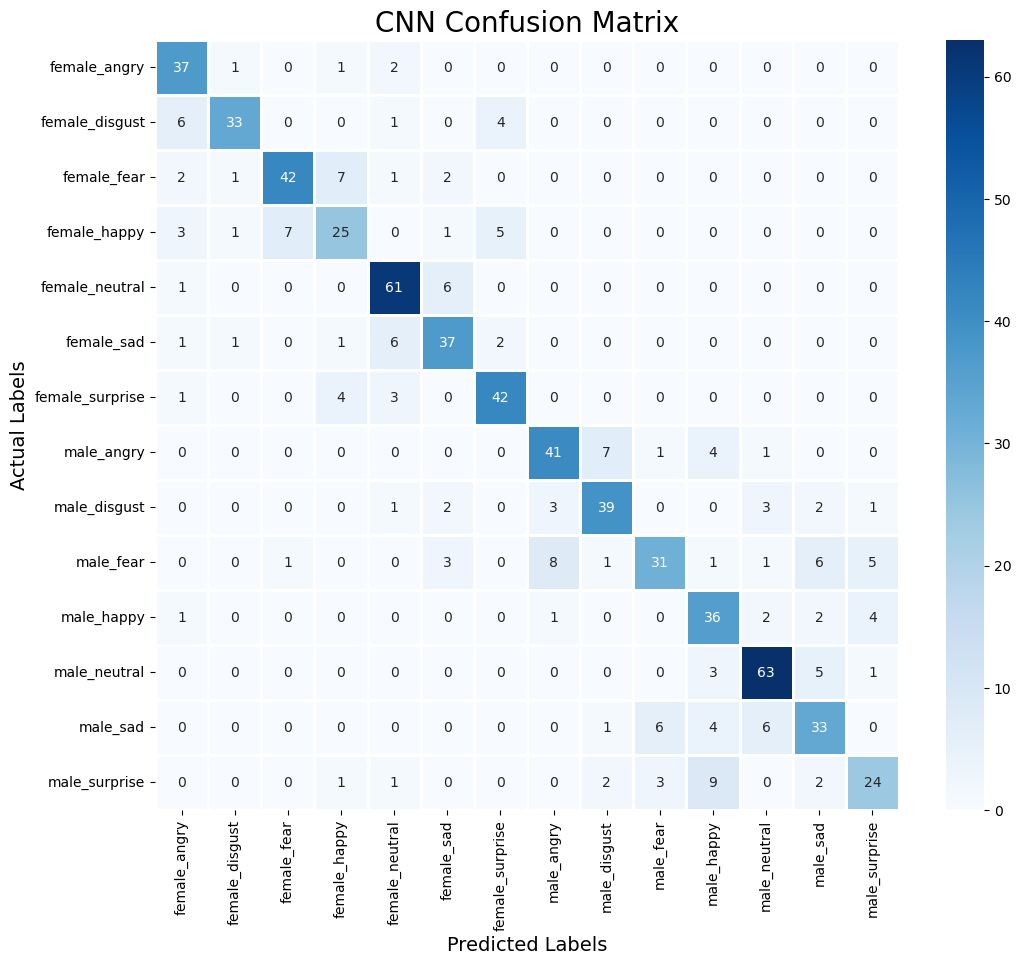

In [100]:
#CNN
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('CNN Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

# Classification Report Using CNN

In [101]:
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

   female_angry       0.71      0.90      0.80        41
 female_disgust       0.89      0.75      0.81        44
    female_fear       0.84      0.76      0.80        55
   female_happy       0.64      0.60      0.62        42
 female_neutral       0.80      0.90      0.85        68
     female_sad       0.73      0.77      0.75        48
female_surprise       0.79      0.84      0.82        50
     male_angry       0.77      0.76      0.77        54
   male_disgust       0.78      0.76      0.77        51
      male_fear       0.76      0.54      0.63        57
     male_happy       0.63      0.78      0.70        46
   male_neutral       0.83      0.88      0.85        72
       male_sad       0.66      0.66      0.66        50
  male_surprise       0.69      0.57      0.62        42

       accuracy                           0.76       720
      macro avg       0.75      0.75      0.75       720
   weighted avg       0.76   

After completing the all training part we got good accuracy using CNN so we plot the confusion matrix and classification report.

In [102]:
model_name = 'model_cnn.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /kaggle/working/saved_models/model_cnn.h5 


In [103]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [104]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights('/kaggle/working/saved_models/model_cnn.h5')
print("Loaded model from disk")

Loaded model from disk


# LIVE DEMO

In [171]:
data, sampling_rate = librosa.load("/kaggle/input/record/record.wav")

In [172]:
import os
import pandas as pd
import librosa
import glob 

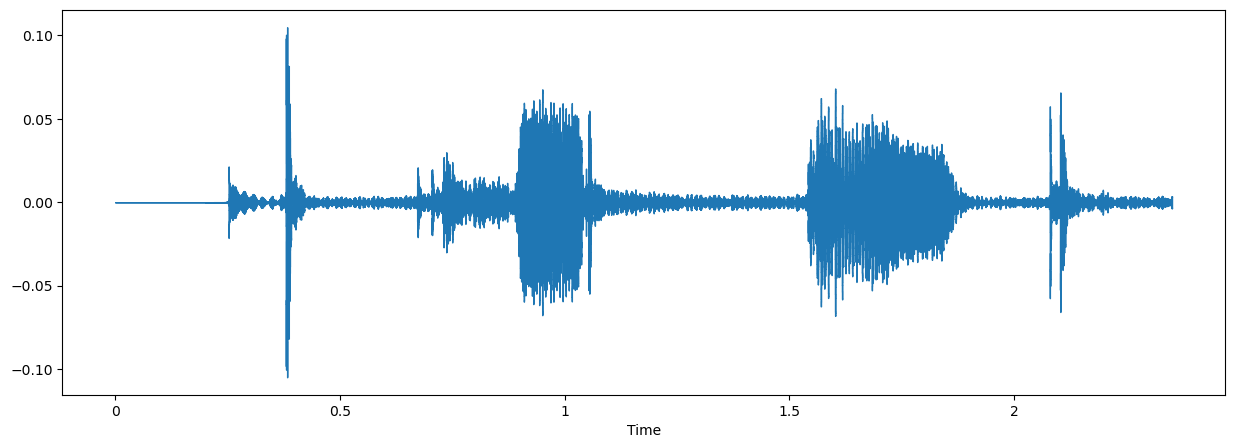

In [164]:
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

In [176]:
from scipy import signal

# Load the audio file
file_path = '/kaggle/input/record/record.wav'
audio, sample_rate = sf.read(file_path)

# Resample the audio to the desired sample rate
target_sample_rate = 22050*2
if sample_rate != target_sample_rate:
    audio = signal.resample(audio, int(len(audio) * target_sample_rate / sample_rate))
    sample_rate = target_sample_rate

# Extract MFCC features from the audio
mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13), axis=0)
features = mfccs
livedf = features

# Process the extracted features as needed
# ...

# Use the features for speech emotion recognition
# ...


In [177]:
livedf= pd.DataFrame(data=livedf)
livedf = livedf.stack().to_frame().T
livedf

,0,1,2,3,4,5,6,7,8,9,10,11,12
,0,0,0,0,0,0,0,0,0,0,0,0,0
0,-718.342885,10.581012,-10.172728,7.751628,-6.042898,4.587144,-3.717932,2.946361,-2.501064,2.034555,-1.795084,1.480193,-1.347119


In [178]:
dim2= np.expand_dims(livedf, axis=2)

In [179]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad or truncate the sequence length to 20
maxlen = 20
dim2_padded = pad_sequences(twodim, maxlen=maxlen, dtype='float32', padding='post', truncating='post', value=0.0)

# Use the padded input data to make predictions
livepreds = loaded_model.predict(twodim_padded, batch_size=32, verbose=1)


1/1 [==============================] - 0s 36ms/step


In [180]:
result = (encoder.inverse_transform((livepreds)))
result

array([['female_sad']], dtype=object)